This model is using the same structure as the report explains, but on a character level instead of word.

In [140]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [141]:
words = open("names.txt", "r").read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [142]:
len(words)

32033

In [143]:
# Build character vocabulary and mappings
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [144]:
block_size = 3 # amount of previous characters to determine next
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print("".join(itos[i] for i in context), "---->", itos[ix])
        context = context[1:] + [ix] # crop context and append next character

X = torch.tensor(X)
Y = torch.tensor(Y)

In [145]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [146]:
def build_dataset(words):
    block_size = 3 # amount of previous characters to determine next
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix] # crop context and append next character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [147]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [148]:
sum(p.nelement() for p in parameters)

3481

In [149]:
# Cross_entropy does the work similar to:
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims=True)
#loss = -prob[torch.arange(32), Y].log().mean()

In [150]:
for p in parameters:
    p.requires_grad = True

In [103]:
# step size interval: 0.001 to 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [104]:
lri = []
losses = []

for i in range(1000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # shape is (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # shape becomes (32, 100)
    logits = h @ W2 + b2 # shape becomes (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    losses.append(loss.item())
    
#print(loss.item())

17.59165382385254
17.654232025146484
19.924545288085938
21.672775268554688
18.83473014831543
20.463443756103516
22.30120849609375
19.263795852661133
16.60831069946289
18.3123779296875
22.158559799194336
21.71809959411621
19.111101150512695
21.05081558227539
21.758560180664062
18.80860137939453
19.697113037109375
14.8412504196167
18.458879470825195
19.88934326171875
17.250713348388672
18.338350296020508
20.127750396728516
18.414051055908203
20.16300392150879
18.571081161499023
17.713478088378906
17.8620548248291
18.244749069213867
19.31345558166504
17.281661987304688
16.72886085510254
19.4190673828125
18.955839157104492
22.504051208496094
15.911368370056152
17.438880920410156
18.696733474731445
18.435894012451172
18.43966293334961
17.43942642211914
16.13129997253418
20.503437042236328
17.48929786682129
19.659841537475586
18.7469482421875
19.658645629882812
18.034460067749023
16.82923126220703
14.76037883758545
14.76603889465332
19.74026870727539
18.19875144958496
18.288787841796875
15.8

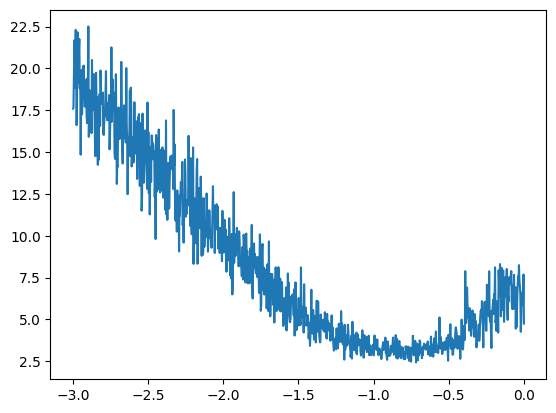

In [105]:
plt.plot(lri, losses)

In [ ]:
# .1 seems to be a good stepping size

In [151]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [209]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,15), generator=g)
W1 = torch.randn((45, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [210]:
sum(p.nelement() for p in parameters)

22332

In [211]:
for p in parameters:
    p.requires_grad = True

In [212]:
losses = []
steps = []

In [215]:
for i in range(300000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # shape is (32, 3, 2)
    h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # shape becomes (32, 100)
    logits = h @ W2 + b2 # shape becomes (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 200000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    losses.append(loss.log10().item())
    steps.append(i)

print(loss.item())

2.1616721153259277


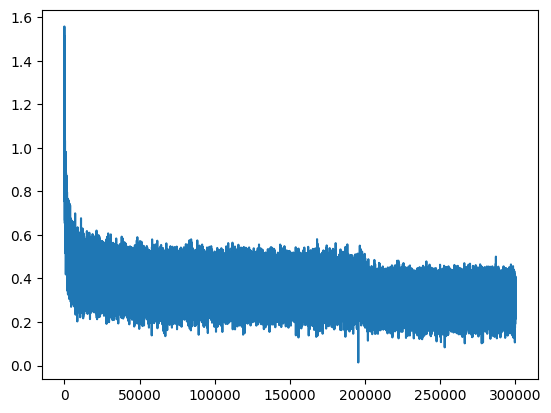

In [216]:
plt.plot(steps, losses)

In [217]:
# evaluation on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 45) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0520, grad_fn=<NllLossBackward0>)

In [218]:
# evaluation
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 45) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1502, grad_fn=<NllLossBackward0>)

In [222]:
# sampling from the model:

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

carpah.
amille.
khi.
mili.
tatyannah.
sae.
rahnen.
deliah.
jareen.
neziah.
